In [1]:
import numpy as np
import pandas as pd
import torch
from NashAgent_lib import *
from RAT_env import *
from NashRL import *
import matplotlib.pyplot as plt
from collections import Counter


def predict_action(nn,states):
    if len(states.shape) > 2:
        B, A, D = states.shape  # B = batch size (10), A = agents (3), D = 255
        flat_states = states.view(B * A, D)  # Flatten to shape (30, 255)
        # Forward pass through action_net
        action_list = nn.forward(input=flat_states)
        # Reshape back to (10, 3, -1)
        action_list = action_list.view(B, A, -1)
        return action_list
    else:
        action_list = nn.forward(input=states) 

        return action_list

def evaluate_action_network(rat_env, action_network, n_episodes):
    
    action_network.eval()

    reward_buffer = []
    action_buffer = []
    for i in range(n_episodes):
        rat_env.reset()
        for t in range(0, 30):
            current_state, _, _ = rat_env.get_state()
            state = expand_list(current_state, rat_env.n_users)
            actions = torch.argmax(predict_action(action_network, state[:, :rat_env.n_stations]), dim=1)
            _, _, _, reward = rat_env.step(actions.detach())
            
            action_buffer.append(actions)
            reward_buffer.append(reward)
    
    return reward_buffer, action_buffer




def plot_reward(reward_buffer):
    n_runs = len(reward_buffer)
    n_agents = len(reward_buffer[0])
    
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))

    for i in range(n_agents):
        ax = axes[i // 5, i % 5]
        agent_rewards = np.array([reward_buffer[run][i] for run in range(n_runs)])
        
        ax.plot(range(n_runs), agent_rewards, label=f"Agent {i+1}")

        ax.set_title(f"Agent {i+1}")
        ax.set_xlabel("Step")
        ax.set_ylabel("Reward")
        ax.grid(True)
        ax.legend()

    fig.suptitle("Reward Evolution for Each Agent Across Runs", fontsize=16)
    plt.tight_layout()
    plt.show()

def plot_actions(actions_buffer):
    n_runs = len(actions_buffer)
    n_agents = len(actions_buffer[0])
    
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))

    for i in range(n_agents):
        ax = axes[i // 5, i % 5]
        agent_actions = np.array([int(torch.round(actions_buffer[run][i])) for run in range(n_runs)])
        ax.plot(range(n_runs), agent_actions, label=f"Agent {i+1}")

        ax.set_title(f"Agent {i+1}")
        ax.set_xlabel("Step")
        ax.set_ylabel("Station chosen")
        ax.grid(True)
        ax.legend()

    fig.suptitle("Stations Chosen by Each Agent Across Runs", fontsize=16)
    plt.tight_layout()
    plt.show()

Initialize enviroment

c:\Users\alvar\Documents\TELECO\cuarto\Thesis\Nash_DQN_RAT\RAT_env.py:346: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(position[0], position[1], c=color, label=f'User (RAT {rat})', s=10)


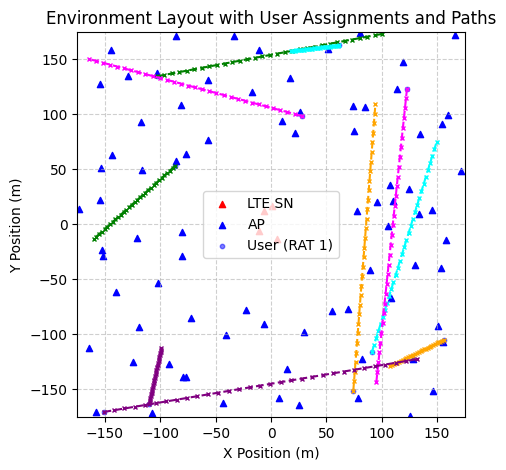

In [2]:
# Parameters for the Multi-RAT Network
user_area_width = 100
ltesn_area_width = 50
n_aps = 81
n_users = 10
n_steps = 30
cqi_dataset = pd.read_csv("cqi_distance.csv")
rssi_dataset = pd.read_csv("rssi_distance.csv")

rat_env = Multi_RAT_Network(user_area_width, ltesn_area_width, n_users, n_aps, cqi_dataset, rssi_dataset, n_steps, plot=True)

In [3]:
action_network = PermInvariantQNN(n_users = rat_env.n_users, n_stations = rat_env.n_stations, out_dim= rat_env.n_stations, lat_dims=512, layers=1)
action_network.load_state_dict(torch.load("Action_Net.pt"))
rewards,actions = evaluate_action_network(rat_env, action_network, n_episodes = 150)


C:\Users\alvar\AppData\Local\Temp\ipykernel_8608\2626173528.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  action_network.load_state_dict(torch.load("Action_Net.pt"))


In [4]:
APs_chosen = [value.item() for action in actions for value in action if value.item() > 3]
counted_aps = Counter(APs_chosen)
LTEs_chosen = [value.item() for action in actions for value in action if value.item() <= 3]
counted_ltes = Counter(LTEs_chosen)
average_LTE_reward = np.mean([reward for reward, action in zip(rewards, actions) if any(value.item() <= 3 for value in action)])
average_AP_reward = np.mean([reward for reward, action in zip(rewards, actions) if any(value.item() > 3 for value in action)])
all_rewards = torch.cat(rewards).numpy()
total_sn_chosen =  len(APs_chosen) + len(LTEs_chosen)
disconnections = np.sum(all_rewards < 0)

print(f"TEST RESULTS with {n_users} users in 150 episodes ({total_sn_chosen} stations chosen)")
print("-----------------------------------------")
print(f"{len(counted_aps)} APs chosen {len(APs_chosen)} times ({100 * len(APs_chosen) / (len(APs_chosen) + len(LTEs_chosen)):.2f}%) | {len(counted_ltes)} LTEs chosen {len(LTEs_chosen)} times ({100 * len(LTEs_chosen) / (len(APs_chosen) + len(LTEs_chosen)):.2f}%)")
print(f"User disconnected {disconnections} times ({(disconnections / total_sn_chosen):.5f} %)")
print(f"Average reward in LTEs: {average_LTE_reward:.3f} --> {average_LTE_reward * 600:.3f} Mb/s")
print(f"Average reward in APs: {average_AP_reward:.3f} --> {average_AP_reward * 600:.3f} Mb/s")
print("-----------------------------------------")
print(f"LTEs chosen :", counted_ltes)
print(f"APs chosen :", counted_aps)


TEST RESULTS with 10 users in 150 episodes (45000 stations chosen)
-----------------------------------------
15 APs chosen 6660 times (14.80%) | 4 LTEs chosen 38340 times (85.20%)
User disconnected 0 times (0.00000 %)
Average reward in LTEs: 0.134 --> 80.280 Mb/s
Average reward in APs: 0.139 --> 83.612 Mb/s
-----------------------------------------
LTEs chosen : Counter({0: 13020, 3: 10800, 1: 8220, 2: 6300})
APs chosen : Counter({37: 690, 71: 660, 42: 660, 14: 510, 18: 480, 55: 450, 60: 450, 58: 450, 33: 420, 41: 420, 51: 420, 62: 390, 35: 390, 8: 150, 39: 120})


Let's play with tau: This are the results with 1e-2:

TEST RESULTS with 10 users in 150 episodes (45000 stations chosen)

25 APs chosen 7470 times (16.60%) | 4 LTEs chosen 37530 times (83.40%)
User disconnected 300 times (0.00667 %)
Average reward in LTEs: 0.135 --> 80.883 Mb/s
Average reward in APs: 0.140 --> 83.728 Mb/s
LTEs chosen : Counter({3: 10140, 0: 9690, 1: 8880, 2: 8820})
APs chosen : Counter({33: 720, 42: 690, 51: 630, 62: 570, 41: 540, 58: 540, 60: 450, 11: 420, 55: 420, 37: 390, 35: 390, 14: 360, 18: 360, 71: 300, 8: 270, 39: 120, 73: 60, 54: 30, 53: 30, 6: 30, 38: 30, 81: 30, 46: 30, 56: 30, 5: 30})

Let's see with 5*1e-2: we have more variability and slightly more APs are choosen but also twice the error rate, maybe when it works better this can be tuned but for now with 1e-2 works pretty nice, what if smaller though?
let's try 5e-1, with this again we reduce the error but also the variabilty.

This are the results with tau = 5e-1:

TEST RESULTS with 10 users in 150 episodes (45000 stations chosen)
16 APs chosen 7140 times (15.87%) | 4 LTEs chosen 37860 times (84.13%)
User disconnected 30 times (0.00067 %)
Average reward in LTEs: 0.126 --> 75.547 Mb/s
Average reward in APs: 0.130 --> 77.914 Mb/s
LTEs chosen : Counter({2: 13530, 3: 9450, 1: 7920, 0: 6960})
APs chosen : Counter({33: 660, 51: 630, 37: 630, 71: 600, 41: 540, 18: 540, 14: 510, 55: 510, 42: 420, 35: 420, 62: 420, 8: 360, 58: 360, 60: 330, 11: 180, 40: 30})




 Let's leave it like this and play with gamma.For tweaking gamma you can try 0.97 and 0.95, right now is at 0.99

 with 0.97:

 TEST RESULTS with 10 users in 150 episodes (45000 stations chosen)
15 APs chosen 6420 times (14.27%) | 4 LTEs chosen 38580 times (85.73%)
User disconnected 0 times (0.00000 %)
Average reward in LTEs: 0.124 --> 74.389 Mb/s
Average reward in APs: 0.127 --> 76.179 Mb/s
LTEs chosen : Counter({0: 11910, 3: 10950, 1: 8910, 2: 6810})
APs chosen : Counter({14: 660, 71: 600, 37: 570, 18: 570, 62: 540, 55: 510, 8: 450, 41: 390, 51: 390, 60: 360, 58: 330, 42: 270, 33: 270, 39: 270, 35: 240})

With 0.95 a bit more Aps selected but some erros, let's leave it with 0.97


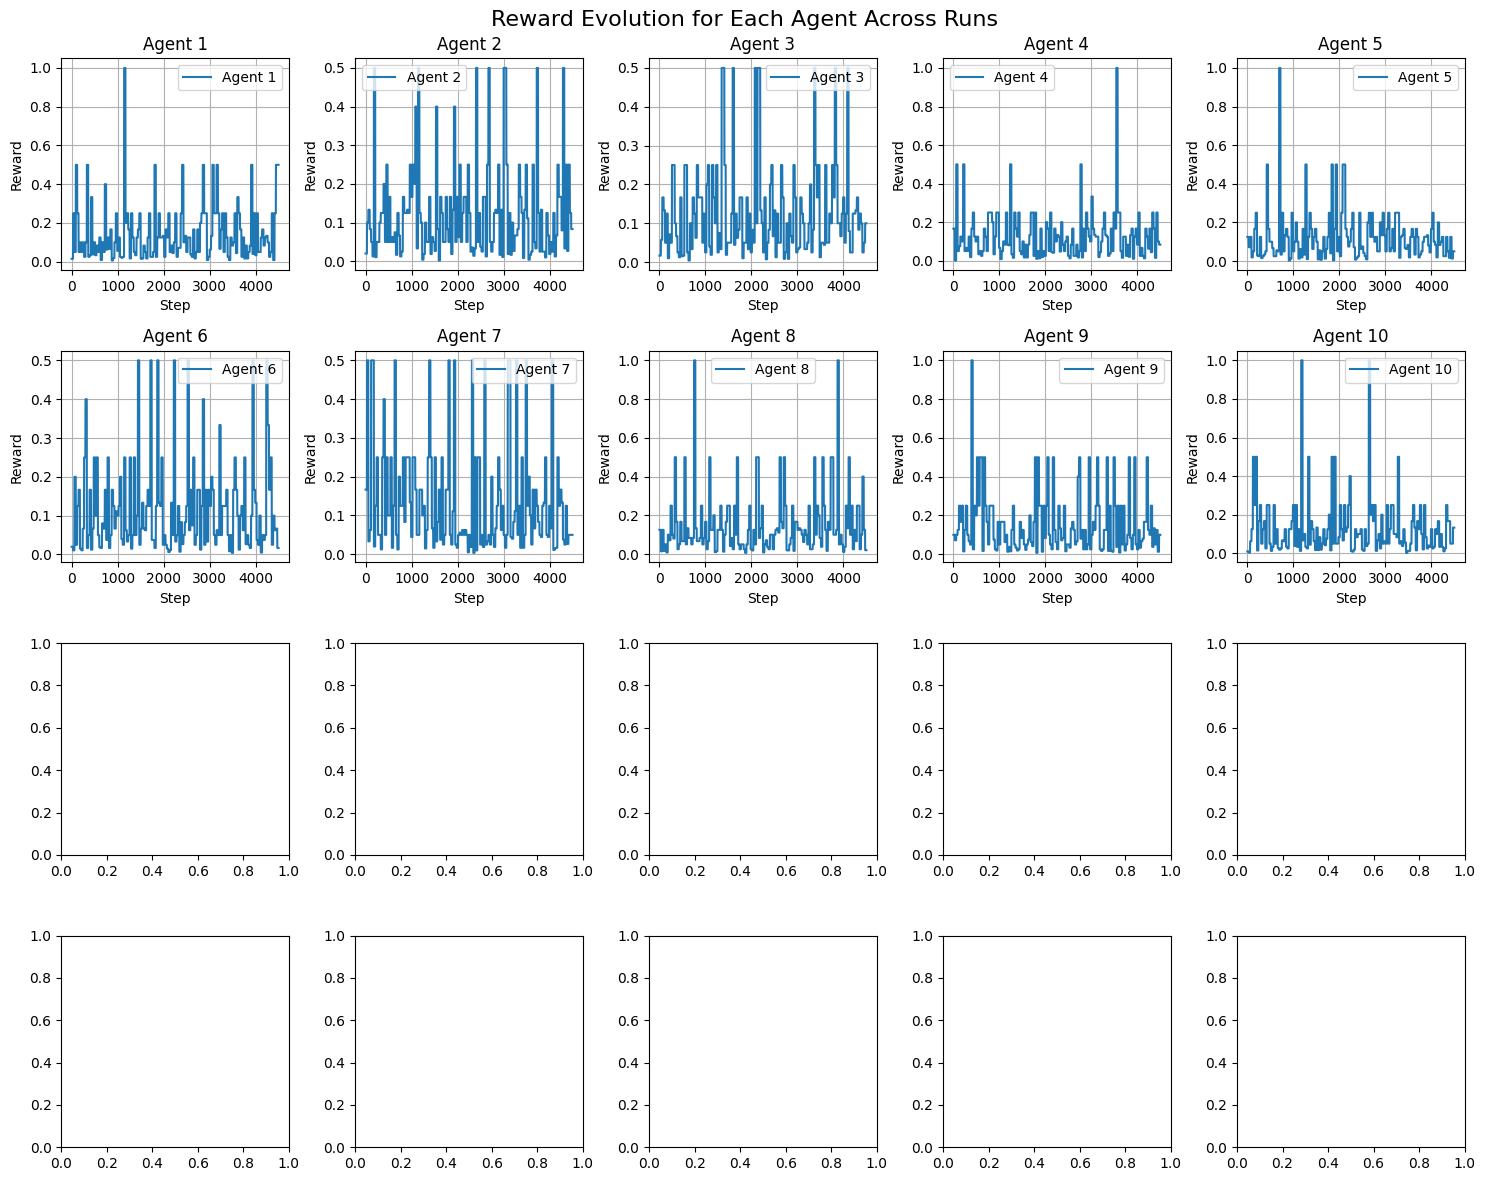

In [5]:
plot_reward(rewards)

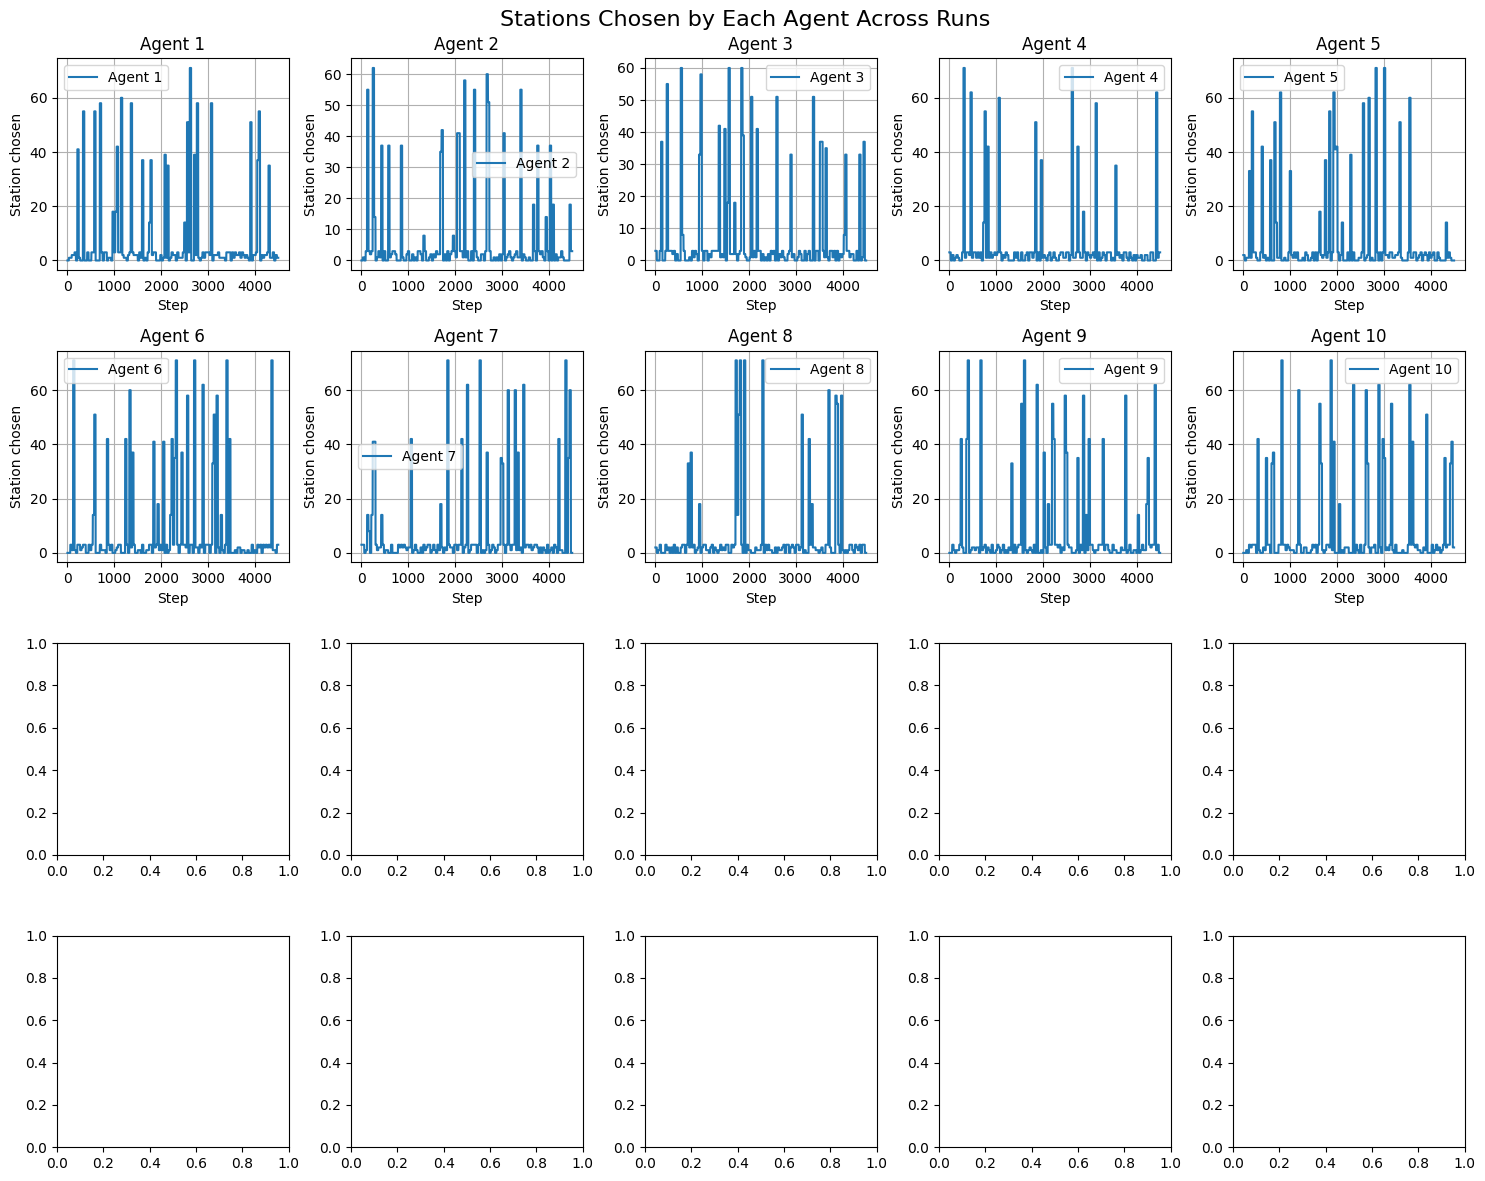

In [6]:
plot_actions(actions)